<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [79]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [80]:
from sklearn.model_selection import train_test_split,KFold, cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import Lasso, ElasticNet, Ridge, LassoCV, ElasticNetCV, \
RidgeCV, LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, \
mean_squared_error

import statsmodels.formula.api as sm
import statsmodels.api as smf

In [81]:
pd.set_option('display.max_columns', 100)
# retrieve dataframes
fixeddf = pd.read_pickle("./fixeddf.pkl")
locationdf = pd.read_pickle("./locationdf.pkl")
universaldf =pd.read_pickle("./universaldf.pkl")
variabledf = pd.read_pickle("./variabledf.pkl")
# retrieve stored y-residual variables
%store -r yrestrain
%store -r yrestest
%store -r FixedCoefs

In [82]:
# join all dfs together
dfs = [fixeddf, locationdf, universaldf, variabledf]
dfs = pd.concat(dfs, axis=1)
dfs.shape

(1448, 113)

In [83]:
# split data into train and test
X = dfs.drop('SalePrice', axis=1)
Xtrain = X[X.YrSold != 2010]
y_train = yrestrain
Xtest = X[X.YrSold == 2010]
y_test = yrestest


In [84]:
# drop saleprice from universaldf
universaldf.drop(['SalePrice','YrSold'], axis=1, inplace=True)

In [85]:
# write function to slice and dice X variable
ss = StandardScaler()
def slicex(colcats):
    Xtrn = Xtrain[colcats.columns] 
    Xtst = Xtest[colcats.columns]            
    # standardize X VALUES using list of x variables
    Xtrnstd = pd.DataFrame(ss.fit_transform(Xtrn), columns=colcats.columns)
    Xtststd = pd.DataFrame(ss.transform(Xtst), columns=colcats.columns)
    return Xtrnstd, Xtststd


Text(0,0.5,'distance from predicted sale price (USD)')

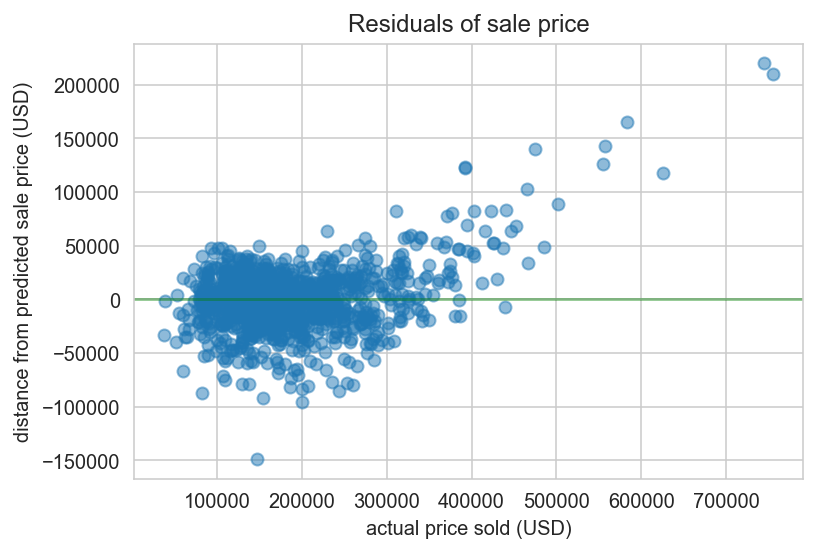

In [86]:
#GRAPH OF RESIDUALS (predicted - actual) SQUARED FROM SIMPLE LINEAR REGRESSION WITH FIXED VARIABLES ONLY
plt.axhline(c = 'g', alpha = .4)
plt.scatter(dfs.SalePrice[dfs.YrSold != 2010], yrestrain, alpha = .5)
plt.title('Residuals of sale price')
plt.xlabel('actual price sold (USD)')
plt.ylabel('distance from predicted sale price (USD)')

-> shows a tendency of the model to underpredict house prices, especially as absolute sale prices increase.

In [87]:
# run regression of price against renovatable features
X_train = slicex(variabledf)[0]
X_test = slicex(variabledf)[1]
X_train.head()

C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\schen24\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data wit

,Functional,BsmtCond,OverallQual,CentralAir,GarageFinish,WoodDeckSF,FireplaceQu,ExterCond,BsmtFinType,OverallCond,HeatingQC,Electrical,GarageCond,OpenPorchSF,GarageQual,RoofShingle,ExterQual,Fence,PavedDrive,EnclosedPorch,KitchenQual,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Other,Exterior1st_Plywood,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,RoofStyle_Hip,RoofStyle_Other
0,0.233656,0.110115,0.641103,0.256901,0.313176,-0.755039,-1.027704,-0.247806,0.965343,-0.521959,0.878370,0.310193,0.262221,0.208047,0.259641,0.116201,1.053921,-0.478839,0.300995,-0.348543,0.730500,-0.208173,-0.423435,-0.419567,-0.191195,-0.272166,1.336423,-0.407875,-0.141365,-0.493624,-0.149786
1,0.233656,0.110115,-0.087345,0.256901,0.313176,1.654929,0.625953,-0.247806,0.274497,2.200191,0.878370,0.310193,0.262221,-0.718356,0.259641,0.116201,-0.708599,-0.478839,0.300995,-0.348543,-0.775345,-0.208173,-0.423435,2.383407,-0.191195,-0.272166,-0.748266,-0.407875,-0.141365,-0.493624,-0.149786
2,0.233656,0.110115,0.641103,0.256901,0.313176,-0.755039,0.625953,-0.247806,0.965343,-0.521959,0.878370,0.310193,0.262221,-0.080505,0.259641,0.116201,1.053921,-0.478839,0.300995,-0.348543,0.730500,-0.208173,-0.423435,-0.419567,-0.191195,-0.272166,1.336423,-0.407875,-0.141365,-0.493624,-0.149786
3,0.233656,1.911476,0.641103,0.256901,-0.809333,-0.755039,1.177172,-0.247806,0.274497,-0.521959,-0.174024,0.310193,0.262221,-0.186814,0.259641,0.116201,-0.708599,-0.478839,0.300995,4.114291,0.730500,-0.208173,-0.423435,-0.419567,-0.191195,-0.272166,-0.748266,2.451732,-0.141365,-0.493624,-0.149786
4,0.233656,0.110115,1.369552,0.256901,0.313176,0.797693,0.625953,-0.247806,0.965343,-0.521959,0.878370,0.310193,0.262221,0.557346,0.259641,0.116201,1.053921,-0.478839,0.300995,-0.348543,0.730500,-0.208173,-0.423435,-0.419567,-0.191195,-0.272166,1.336423,-0.407875,-0.141365,-0.493624,-0.149786


In [88]:
# run simple linear regression
lm = LinearRegression()
model = lm.fit(X_train, y_train)
yhat_skl = lm.predict(X_test)
print('R2 baseline:',model.score(X_train, y_train))
print('R2 baseline:',model.score(X_test, y_test))
print('Mean squared error:', mean_squared_error(y_test, yhat_skl))

SLRloc = [model.score(X_test, y_test), np.nan, mean_squared_error(y_test, yhat_skl)]

R2 baseline: 0.16460472114233615
R2 baseline: 0.05794772978664886
Mean squared error: 859392451.5147258


In [89]:
### Map LR coefficients to its column names
VarCoefs = pd.DataFrame(lm.coef_, index= variabledf.columns, columns=['Coef'])
VarCoefs['AbsCoef'] = abs(VarCoefs.Coef)
VarCoefs.sort_values(by='AbsCoef', ascending=False).head(10)

,Coef,AbsCoef
Exterior1st_VinylSd,-9908.044640,9908.044640
Exterior1st_Wd Sdng,-6714.092183,6714.092183
Exterior1st_HdBoard,-6698.367458,6698.367458
Exterior1st_MetalSd,-6167.547595,6167.547595
OverallCond,5843.732434,5843.732434
Exterior1st_Plywood,-5539.244160,5539.244160
OverallQual,5267.599077,5267.599077
Functional,5200.748882,5200.748882
BsmtCond,-3908.039858,3908.039858
Exterior1st_Other,-3493.260206,3493.260206


In [90]:
# the R2 is terrible, and the top coefficients don't really make sense

In [91]:
# now let's try Lasso regression on all variable factors.
kf_shuffle = KFold(n_splits=10,shuffle=True)
LassCV = LassoCV(n_alphas=500, cv=kf_shuffle)
LassCV.fit(X_train, y_train)
### View alpha and score
LassCV.alpha_, LassCV.score(X_train, y_train)
### Setup Lasso regression using alpha calculated
Lass = Lasso(alpha=LassCV.alpha_)
### Run cross validated lasso
LassScore = cross_val_score(Lass,X_test, y_test, cv=kf_shuffle)
predictions = cross_val_predict(Lass,X_test, y_test, cv=kf_shuffle)
print('Mean Lasso score:', np.mean(LassScore))
print('Std Lasso score:', np.std(LassScore))
print('Mean squared error:', mean_squared_error(y_test, predictions))

Mean Lasso score: -0.33355064823102987
Std Lasso score: 0.3762469553671883
Mean squared error: 1205513249.4947207


In [92]:
### Run Lasso to get the most predictive coefficients.
Lass.fit(X_train, y_train)
### Map lasso coefficients to its column names
dfl = pd.DataFrame(Lass.coef_, index= variabledf.columns, columns=['Coef'])
dfl['AbsCoef'] = abs(dfl.Coef)
LassoCoefs = dfl[~(abs(dfl['Coef']) == 0)].sort_values(by='AbsCoef', ascending=False)
LassoCoefs.head(10)

,Coef,AbsCoef
Exterior1st_VinylSd,-6199.904180,6199.904180
OverallCond,5799.333578,5799.333578
OverallQual,5133.795632,5133.795632
Functional,5021.642076,5021.642076
Exterior1st_Wd Sdng,-4124.327018,4124.327018
Exterior1st_HdBoard,-3891.309867,3891.309867
BsmtCond,-3822.695063,3822.695063
Exterior1st_Plywood,-3567.743065,3567.743065
Exterior1st_MetalSd,-3458.555865,3458.555865
FireplaceQu,-2989.436870,2989.436870


In [93]:
# the score is even worse! 

CONCLUSION: Regression with just the residuals should be abandoned due to homoskedascity. the R2 fit is very poor and producing unintuitive top renovatables both in linear and Lasso regression. 

In [94]:
# let's now try running fixed and renovatable factors together.

In [95]:
#recall baseline SLR for all fixed factors
baseSLR = [0.8564585796009494, np.nan, 912550097.1731029]

In [96]:
# declare var reno for variable factors
#run regression below and successively remove best features to produce 'top5reno' with highest R2 (code was modif slightly)
reno = list(variabledf.columns)

In [97]:
# let's add top 5 reno features to fixed features one by one
allfixed = pd.concat([fixeddf, locationdf], axis=1)
#count = 1
score = 0
res = []
for r in reno:
    allfeat = pd.concat([allfixed, dfs[r]], axis=1)
    X_train = slicex(allfeat)[0]
    X_test = slicex(allfeat)[1]
    # run simple linear regression
    model = lm.fit(X_train, y_train)
    yhat_skl = lm.predict(X_test)

    score = model.score(X_test, y_test)
    res.append(score)



C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\schen24\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data wit

C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\schen24\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\schen24\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Da

C:\Users\schen24\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\schen24\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int3

In [98]:
dfl = pd.DataFrame(res, index= reno, columns=['R2score'])
top5reno = list(dfl.sort_values(by='R2score', ascending=False).index[:5])
top5reno

['KitchenQual', 'Functional', 'OverallQual', 'RoofStyle_Hip', 'ExterQual']

In [99]:
reno = top5reno

In [100]:
# re-initialize X variables
Xtrain = X[(X.YrSold != 2010)]
Xtest = X[(X.YrSold == 2010)]
y_train = dfs.SalePrice[(dfs.YrSold != 2010)]
y_test = dfs.SalePrice[(dfs.YrSold == 2010)]

In [101]:
# let's add top 5 reno features to fixed features one by one
allfeat = pd.concat([fixeddf, locationdf], axis=1)
count = 1
score = 0
for r in reno:
    allfeat = pd.concat([allfeat, dfs[r]], axis=1)
    X_train = slicex(allfeat)[0]
    X_test = slicex(allfeat)[1]
    # run simple linear regression
    model = lm.fit(X_train, y_train)
    yhat_skl = lm.predict(X_test)
    print('run:', count)
    print('R2 baseline train:',model.score(X_train, y_train))
    print('R2 baseline test:',model.score(X_test, y_test))
    print('Mean squared error:', mean_squared_error(y_test, yhat_skl))
    
    SLRloc = [model.score(X_test, y_test), np.nan, mean_squared_error(y_test, yhat_skl)]
    
    print('Fixed features (mean, stdev, MSE) only:\n', baseSLR)
    print('Fixed + renovatable features (mean, stdev, MSE) only:\n', SLRloc)
    #the R2 has improved upon adding renovatable features, and MSE has reduced.
    
    print('subtract diff in MSE and square root it (Mdsqrt):\n', np.sqrt(baseSLR[2] - SLRloc[2]))
    
    # print top 10 coefficients by absolute value
    AllCoefs = pd.DataFrame(lm.coef_, index= allfeat.columns, columns=['Coef'])
    AllCoefs['AbsCoef'] = abs(AllCoefs.Coef)
    print(AllCoefs.sort_values(by='AbsCoef', ascending=False).head(10))
    # only 'overall quality' made it into final list
    if model.score(X_test, y_test) > score :
        score = model.score(X_test, y_test)
        MSEdiff = baseSLR[2] - SLRloc[2]
        MSEdiffsqrt = np.sqrt(MSEdiff)
        ct = count
        name = r
    count+=1
print('\nbest run:', ct)
print('best score:', score)
print('MSEdiffsqrt:', MSEdiffsqrt)

C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\schen24\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data wit

run: 1
R2 baseline train: 0.8780755711771754
R2 baseline test: 0.865199789508368
Mean squared error: 856978737.1555591
Fixed features (mean, stdev, MSE) only:
 [0.8564585796009494, nan, 912550097.1731029]
Fixed + renovatable features (mean, stdev, MSE) only:
 [0.865199789508368, nan, 856978737.1555591]
subtract diff in MSE and square root it (Mdsqrt):
 7454.620045149437
                              Coef       AbsCoef
GrLivArea             34452.594327  34452.594327
GarageType_Attchd     17243.567849  17243.567849
GarageType_Detchd     15416.940144  15416.940144
TotalBsmtSF           10798.280544  10798.280544
GarageType_BuiltIn    10290.364394  10290.364394
Neighborhood_NridgHt   9930.327944   9930.327944
GarageType_None        9851.111615   9851.111615
KitchenQual            9545.988564   9545.988564
BsmtExposure           8592.311851   8592.311851
Neighborhood_NoRidge   8159.298058   8159.298058
run: 2
R2 baseline train: 0.8838316641686451
R2 baseline test: 0.868298163186898
Mean sq

C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\schen24\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data wit

CONCLUSION: 
1) MSEdiffsqrt is the average absolute distance between predicted and actual values that is explained by 
renovatable factors. adding all 5 factors gives best results, with a MSEdiffsqrt of $10328. 

2) examination of the top 10 coeff is also instructive. Kitchen quality appears in first 2 iterations (it was the top feature in isolation) but was replaced by Overall Quality in later iterations. this implies that some effects that were explained by overall quality (while it was missing) were wrongly attributed to kitchen quality. 

3) to figure out dollar value of individual features, let's print out all the coefficients for the features. 

In [102]:
AllCoefs = pd.DataFrame(lm.coef_, index= allfeat.columns, columns=['Coef'])
AllCoefs['AbsCoef'] = abs(AllCoefs.Coef)
x = AllCoefs.sort_values(by='AbsCoef', ascending=False).loc[reno, :]
x

,Coef,AbsCoef
KitchenQual,5348.196093,5348.196093
Functional,6012.657227,6012.657227
OverallQual,11795.279538,11795.279538
RoofStyle_Hip,3191.590544,3191.590544
ExterQual,4802.702872,4802.702872


In [103]:
print(x.Coef.sum())

31150.4262734953


4) the 'Coef' column indicates the effect in dollars of the renovatable features. The reason this differs from MSEdiffsqrt follows the same logic as 2); so we should better use 'Coef' as a guide. 

5) how to use the model to decide on whether to buy a property: based on the company's appraisal of the house, all variables can be rated. after plugging in all the coefficient values, we can come up with a y value (the expected sale price). if sale price is > asking price, we can shortlist the house. 

6) for a margin of safety, we can dial all the renovatable variables to zero for the base price of house. if asking price < base price, we can start to get very interested. 

7) in our regression, variable factors only added about ~2% to the R2 base score of ~85%, implying that ~13% of the variance in the model is unexplained. to buffer for this, we recommend that the difference between asking price and expected price be at least 13% or more. 

8) attention should be paid to fixed factors as well, and undervalued houses that display the top 10 fixed factors (eg are in the top3 neighbourhoods, good basement exposure and size etc) should be given priority. 
now, as to how much we can sell the house for...

9) since the independent variables have been standardized, every 1SD improvement in renovatable factors will increase house value by ~$31k. 

10) intuitively, incremental improvements in house condition should cost much less than massive overhauls, and we can see below that very high quality houses outperform the lower quality ones in terms of expected vs actual sale price. one tactic would be to target the undervalued 6-8s, and aim to bring them up to 9-10. attention should be paid when remodeling to the kitchen, the functionality of the house, the roofstyle and quality of external materials (appearances count!).

11) due to the ~13% unexplained variance of residuals, the difference in expected profit and cost of renovation should be at least ~13% as well.  

Text(0,0.5,'distance from predicted sale price (USD)')

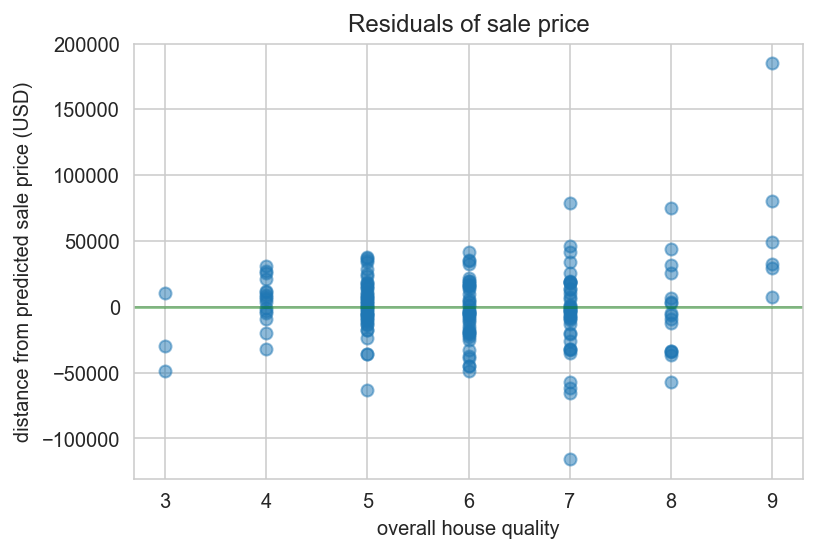

In [104]:
#GRAPH OF RESIDUALS (predicted - actual) FROM SIMPLE LINEAR REGRESSION WITH FIXED VARIABLES ONLY
plt.axhline(c = 'g', alpha = .4)
plt.scatter(dfs.OverallQual[dfs.YrSold == 2010], yrestest, alpha = .5)
plt.title('Residuals of sale price')
plt.xlabel('overall house quality')
plt.ylabel('distance from predicted sale price (USD)')